# Experiments on different methods

In [1]:
import cv2
import numpy as np
import torch
import time

from tqdm import tqdm
from addict import Dict

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties
import seaborn as sns

from generator.flow import FlowManager 
from generator.loader import config_events as config
from generator.loader import EventManager
# from utils.spliter import split_events_voxelized
from utils.spliter import filter_events_by_time_polarity, EventSpatialSplitter
from kernels.pcm import estimatePCM,estimatePCMB, estimatePCMSA
from kernels.correlation import estimateCC
from kernels.opticalflow import estimateOF
from kernels.cmax import estimateCMAX

from utils.visualizer import plot_event_time2d

stsong_font = FontProperties(fname=None, family='STSong')

cmap = mpl.colormaps['tab10']
colors = cmap(np.linspace(0, 1, 10))
colors = np.concatenate([colors]*10,axis=0)
markers = ["s", "^", ">", "o", "*", "v", "<", "P", "X", "D"]*10
linestyles = ["-","-","-","--","-","-","-","-","-","-","-"]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(100) # the same seed for the reproducible results

cuda:0


In [2]:
# Jeon, Young Jin, Ludovic Chatellier, and Laurent David. "Fluid trajectory evaluation based on an ensemble-averaged cross-correlation in time-resolved PIV."
# Experiments in fluids 55.7 (2014): 1766.
def cc(evts):
    return estimateCC(evts,num_bins=5, H=33, W=33, step=1, sigma=0.3, smooth=True)

def of(evts):
    return estimateOF(evts,num_bins=5, H=33, W=33, step=1, sigma=0.3, smooth=True)

def CMAX(evts):
    return estimateCMAX(evts=evts, K=33, sigma2=1.0, n_iter=128, debug=False)

def PCM_B(evts):
    return estimatePCMB(evts)

def PCM_SA(evts):
    return estimatePCMSA(evts)

methods = [cc, of, CMAX, PCM_B, PCM_SA]
m_names = ["VG‑CC","VG‑LK","CMAX","PCM-B","PCM-SA"]

# Spliter 
cfg = Dict(H=256, W=256,
    x_span=33, y_span=33, step=16,
    t_min=0.5, t_max=3.5, min_events=0)

spliter = EventSpatialSplitter(cfg)

# Test_mode_flag = True
Test_mode_flag = False

In [3]:
def plots_error(theta, error, ylabels=['平均端点误差 $[px/ms]$', 'AEE $[px/ms]$'], name='AEE'):
    plt.figure(figsize=(5,3))
    for i, m in enumerate(methods): 
        plt.plot(theta, error[:,i], color=colors[i+1], linestyle=linestyles[i],marker=markers[i], markevery=4, label=m_names[i])
        
    plt.legend(loc=1)
    plt.yscale('log')
    
    plt.xlim([np.min(theta)-0.1, np.max(theta)+0.1])
    # plt.ylim([1e-3, 1.0])
    plt.ylim([0.005, 0.51])
    plt.grid(True)
    xticks_deg = np.linspace(0, 180, 9)
    plt.xticks(xticks_deg)
    
    # ===== 1. 中文标签并保存 =====
    plt.xlabel('速度方向 $\\theta$ [$^\circ$]', fontproperties=stsong_font)
    plt.ylabel(ylabels[0], fontproperties=stsong_font)
    # plt.savefig("output/The_rmse_theta_noise_2d_zh.pdf")
    plt.tight_layout()
    plt.savefig(f"output/Fig_4_1_{name}_zh.pdf")

    # ===== 2. 英文标签并保存 =====
    plt.xlabel('Velocity orientation $\\theta$ [$^\circ$]')
    plt.ylabel(ylabels[1])
    plt.tight_layout()
    plt.savefig(f"output/Fig_4_1_{name}.pdf")
    
    # ===== 3. 显示图像 =====
    plt.title("Estimation Error as a Function of $\\theta$")
    plt.show()

## 3.1 Comparative exp with uniform flow

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [53:45<00:00, 44.18s/it]
/tmp/ipykernel_13933/2662238677.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


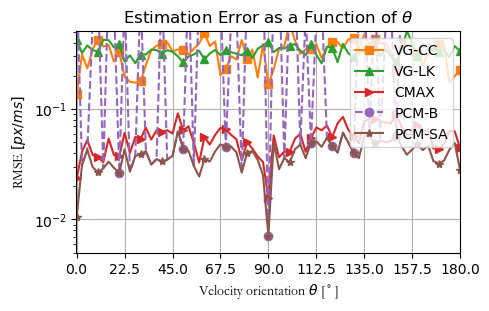

/tmp/ipykernel_13933/2662238677.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


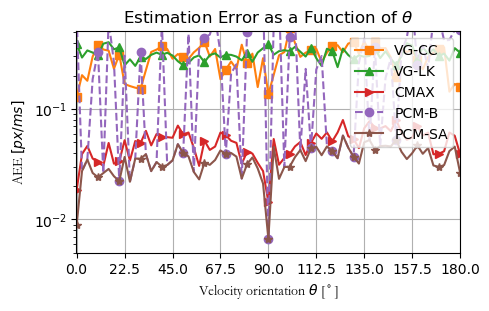

 11%|█         | 8/73 [05:51<47:43, 44.06s/it]

 12%|█▏        | 9/73 [06:36<47:00, 44.08s/it]

 14%|█▎        | 10/73 [07:20<46:21, 44.16s/it]

 15%|█▌        | 11/73 [08:04<45:41, 44.22s/it]

 16%|█▋        | 12/73 [08:49<45:01, 44.28s/it]

 18%|█▊        | 13/73 [09:33<44:12, 44.20s/it]

 19%|█▉        | 14/73 [10:17<43:30, 44.25s/it]

 21%|██        | 15/73 [11:01<42:48, 44.29s/it]

 22%|██▏       | 16/73 [11:46<42:07, 44.34s/it]

 23%|██▎       | 17/73 [12:30<41:19, 44.29s/it]

 25%|██▍       | 18/73 [13:15<40:38, 44.33s/it]

 26%|██▌       | 19/73 [13:59<39:54, 44.35s/it]

 27%|██▋       | 20/73 [14:43<39:12, 44.40s/it]

 29%|██▉       | 21/73 [15:28<38:28, 44.40s/it]

 30%|███       | 22/73 [16:12<37:43, 44.39s/it]

 32%|███▏      | 23/73 [16:57<36:58, 44.37s/it]

 33%|███▎      | 24/73 [17:41<36:09, 44.27s/it]

 34%|███▍      | 25/73 [18:25<35:21, 44.19s/it]

 36%|███▌      | 26/73 [19:09<34:39, 44.25s/it]

 37%|███▋      | 27/73 [19:53<33:52, 44.18s/it]

 38%|███▊      | 28/73 [20:37<33:11, 44.26s/it]

 40%|███▉      | 29/73 [21:22<32:26, 44.25s/it]

 41%|████      | 30/73 [22:06<31:41, 44.23s/it]

 42%|████▏     | 31/73 [22:50<31:00, 44.29s/it]

 44%|████▍     | 32/73 [23:34<30:14, 44.26s/it]

 45%|████▌     | 33/73 [24:18<29:19, 43.99s/it]

 47%|████▋     | 34/73 [25:02<28:38, 44.06s/it]

 48%|████▊     | 35/73 [25:45<27:47, 43.88s/it]

 49%|████▉     | 36/73 [26:29<26:58, 43.74s/it]

 51%|█████     | 37/73 [27:12<26:06, 43.52s/it]

 52%|█████▏    | 38/73 [27:55<25:22, 43.50s/it]

 53%|█████▎    | 39/73 [28:39<24:41, 43.58s/it]

 55%|█████▍    | 40/73 [29:23<24:03, 43.74s/it]

 56%|█████▌    | 41/73 [30:07<23:19, 43.73s/it]

 58%|█████▊    | 42/73 [30:51<22:37, 43.78s/it]

 59%|█████▉    | 43/73 [31:35<21:54, 43.81s/it]

 60%|██████    | 44/73 [32:19<21:16, 44.00s/it]

 62%|██████▏   | 45/73 [33:03<20:33, 44.04s/it]

 63%|██████▎   | 46/73 [33:48<19:50, 44.09s/it]

 64%|██████▍   | 47/73 [34:31<19:04, 44.01s/it]

 66%|██████▌   | 48/73 [35:16<18:22, 44.11s/it]

 67%|██████▋   | 49/73 [36:00<17:40, 44.19s/it]

 68%|██████▊   | 50/73 [36:44<16:57, 44.24s/it]

 70%|██████▉   | 51/73 [37:29<16:13, 44.26s/it]

 71%|███████   | 52/73 [38:13<15:27, 44.18s/it]

 73%|███████▎  | 53/73 [38:57<14:43, 44.18s/it]

 74%|███████▍  | 54/73 [39:41<13:59, 44.18s/it]

 75%|███████▌  | 55/73 [40:25<13:15, 44.22s/it]

 77%|███████▋  | 56/73 [41:10<12:31, 44.22s/it]

 78%|███████▊  | 57/73 [41:54<11:47, 44.21s/it]

 79%|███████▉  | 58/73 [42:38<11:02, 44.19s/it]

 81%|████████  | 59/73 [43:22<10:18, 44.20s/it]

 82%|████████▏ | 60/73 [44:07<09:35, 44.26s/it]

 84%|████████▎ | 61/73 [44:50<08:49, 44.16s/it]

 85%|████████▍ | 62/73 [45:35<08:06, 44.23s/it]

 86%|████████▋ | 63/73 [46:19<07:22, 44.21s/it]

 88%|████████▊ | 64/73 [47:03<06:37, 44.17s/it]

 89%|████████▉ | 65/73 [47:47<05:52, 44.07s/it]

 90%|█████████ | 66/73 [48:31<05:08, 44.09s/it]

 92%|█████████▏| 67/73 [49:15<04:24, 44.15s/it]

 93%|█████████▎| 68/73 [49:59<03:40, 44.04s/it]

 95%|█████████▍| 69/73 [50:43<02:55, 43.83s/it]

 96%|█████████▌| 70/73 [51:26<02:11, 43.74s/it]

 97%|█████████▋| 71/73 [52:09<01:27, 43.51s/it]

 99%|█████████▊| 72/73 [52:52<00:43, 43.49s/it]

100%|██████████| 73/73 [53:36<00:00, 43.40s/it]

100%|██████████| 73/73 [53:36<00:00, 44.06s/it]


findfont: Font family 'STSong' not found.


findfont: Font family ['STSong'] not found. Falling back to DejaVu Sans.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


/tmp/ipykernel_459374/2662238677.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
findfont: Font family 'STSong' not found.


findfont: Font family 'STSong' not found.


findfont: Font family 'STSong' not found.


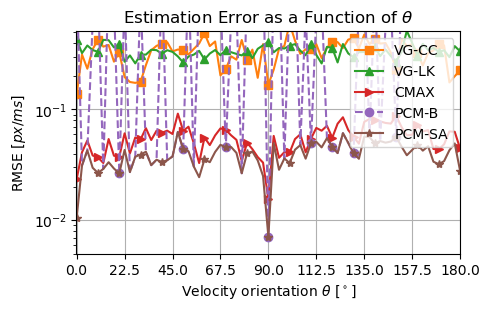

findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5e73' [U+5e73], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u7aef' [U+7aef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u70b9' [U+70b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5e73' [U+5e73], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u7aef' [U+7aef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u70b9' [U+70b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5e73' [U+5e73], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u7aef' [U+7aef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u70b9' [U+70b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


/tmp/ipykernel_459374/2662238677.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
findfont: Font family 'STSong' not found.


findfont: Font family 'STSong' not found.


findfont: Font family 'STSong' not found.


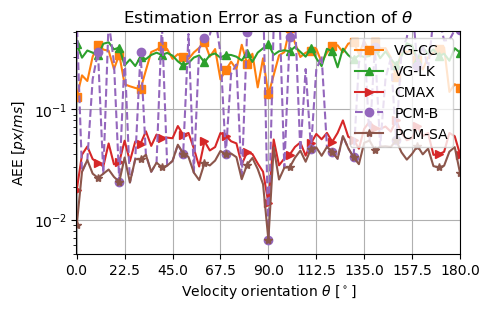

In [4]:
def ExpCom():   
    if Test_mode_flag:
        thetas = np.linspace(0,np.pi/4,3) # simple
    else:
        thetas = np.linspace(0,np.pi,73) # Full cfg


    all_errors = list()
    for i,theta in enumerate(tqdm(thetas)):
        amp = 5.0
        u,v = amp*np.cos(theta), amp*np.sin(theta)

        true_velocity = torch.tensor([u, v]).to(device)
        flow_generator = FlowManager(mode="analytical", name="uniform", uc=u, vc=v)
        flow_func = flow_generator.evaluate
        
        cfg_evts = config()
        cfg_evts.time_length= 4
        cfg_evts.d = 1.0
        cfg_evts.density = 0.02
        case = Dict(source_type="simulator", path=None, cfg=cfg_evts, flow_func=flow_func)
        event_loader = EventManager(**case)

        events, _ = event_loader.load()
        evts = filter_events_by_time_polarity(events, t_min=cfg.t_min, t_max=cfg.t_max, polarity=1)
        spliter.put_data(evts)

        cx = torch.arange(17, 256-17, cfg.step)
        cy = torch.arange(17, 256-17, cfg.step)
    
        errors_theta = list()
        for i,px in enumerate(cx):
            for j,py in enumerate(cy):
                block = spliter.obtain_at(px, py)[:2000]
                e_blocks = list()
                if len(block)<200:
                    e_blocks.append(np.nan)
                    continue
                for method in methods:
                    ret = method(block)
                    v_est, v_loss = ret[0], ret[1]
                    # bias_error = v_est[0][1]-true_velocity[1]
                    bias_error = v_est[0]-true_velocity
                    epe = torch.norm(bias_error).cpu().detach().numpy()
                    e_blocks.append(epe)
            errors_theta.append(np.array(e_blocks))
        all_errors.append(np.array(errors_theta))

    all_errors = np.array(all_errors)
    rmse = np.sqrt(np.nanmean(all_errors*all_errors, axis=1))
    aee = np.nanmean(np.abs(all_errors), axis=1)
    thetas_degree = thetas*180/np.pi

    plots_error(thetas_degree, rmse, ylabels=['均方根误差 $[px/ms]$', 'RMSE $[px/ms]$'], name='RMSE')
    plots_error(thetas_degree, aee,  ylabels=['平均端点误差 $[px/ms]$', 'AEE $[px/ms]$'], name='AEE')

    return all_errors

all_errors = ExpCom()

## 3.2 time exp

[ 200  300  400  500  600  700  800  900 1000 1100 1200 1300 1400 1500
 1600 1700 1800 1900 2000]
(5, 19) (5, 19)


/tmp/ipykernel_13933/383715715.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


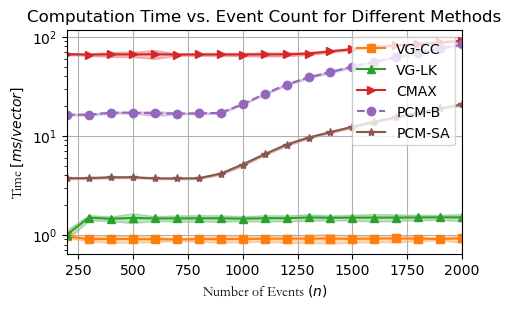

[[ 0.96668426  0.90344568  0.91412058  0.90675921  0.90502276  0.89926419
   0.90413843  0.9080912   0.91019217  0.91326985  0.91750561  0.91607878
   0.91939065  0.91119829  0.91848304  0.92047199  0.91616673  0.90948928
   0.92327982]
 [ 1.00928698  1.49508723  1.45493282  1.485449    1.46708745  1.46757756
   1.47193594  1.47232667  1.45908147  1.47415548  1.47531682  1.50117209
   1.48932077  1.49534318  1.49602181  1.4958595   1.50106842  1.50487586
   1.50210368]
 [66.83434499 66.2119706  66.49511841 66.41987418 66.68141446 66.27936113
  66.32781698 66.36981074 66.30294285 66.47841848 66.52258024 67.79600486
  71.42421326 75.26399106 78.91364149 82.18190652 84.83551009 87.90916598
  91.22649687]
 [16.37756889 16.37686716 17.15534056 17.16288237 16.88501256 16.82478829
  16.87483673 17.09250033 20.88860865 26.4770918  32.98517644 38.90781411
  44.18134655 49.98732008 56.11758096 62.41398082 69.09562603 76.36551621
  83.88792018]
 [ 3.73013089  3.74830259  3.81549548  3.82242272  3

Font 'default' does not have a glyph for '\u4e8b' [U+4e8b], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u4ef6' [U+4ef6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6570' [U+6570], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u91cf' [U+91cf], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8ba1' [U+8ba1], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u7b97' [U+7b97], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65f6' [U+65f6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u95f4' [U+95f4], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u4e8b' [U+4e8b], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u4ef6' [U+4ef6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6570' [U+6570], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u91cf' [U+91cf], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8ba1' [U+8ba1], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u7b97' [U+7b97], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65f6' [U+65f6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u95f4' [U+95f4], substituting with a dummy symbol.


/tmp/ipykernel_459374/383715715.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
findfont: Font family 'STSong' not found.


findfont: Font family 'STSong' not found.


(5, 19) (5, 19)


findfont: Font family 'STSong' not found.


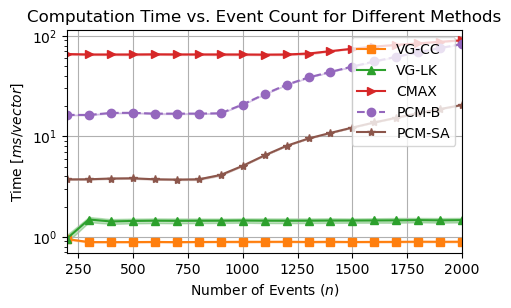

[[ 0.95144666  0.88845976  0.88718135  0.88811618  0.89087665  0.88721332
   0.89027939  0.89142796  0.89331905  0.8932579   0.89457076  0.89083782
   0.89385027  0.88949398  0.89170087  0.89269769  0.89599797  0.8943004
   0.89551045]
 [ 0.96222215  1.4892213   1.42498912  1.44099385  1.44901343  1.44468401
   1.44721207  1.4482012   1.45437691  1.44903156  1.44771299  1.44909231
   1.45397625  1.4543375   1.45758804  1.46139927  1.46874201  1.46117573
   1.46804208]
 [65.83202082 65.18941888 65.18443272 65.19204974 65.43992719 65.28501252
  65.27503044 65.23780927 65.19601885 65.00031079 65.18802778 66.65938849
  70.37618995 74.421883   78.08971453 81.29369721 84.12313146 87.28897858
  90.25032735]
 [16.34393123 16.32409849 17.09905825 17.13930951 16.82613804 16.81906382
  16.84118535 16.95688428 20.73256841 26.26171862 32.60570297 38.50642122
  43.74931923 49.47186337 55.6279594  61.92480565 68.56335539 75.57732975
  82.98734743]
 [ 3.73203637  3.7404698   3.80789891  3.82776501  3.

In [5]:
def ExpTime():   
    if Test_mode_flag:
        ns = np.arange(400,2001,400)
    else:
        ns = np.arange(200,2001,100)
    print(ns)

    # 得到流场
    amp, theta = 5.0, np.pi/8 # random value
    u,v = amp*np.cos(theta), amp*np.sin(theta)
    true_velocity = torch.tensor([u, v]).to(device)
    flow_generator = FlowManager(mode="analytical", name="uniform", uc=u, vc=v)
    flow_func = flow_generator.evaluate

    # 基于上述流场生成仿真数据
    cfg_evts = config()
    cfg_evts.time_length= 6
    cfg_evts.d = 2.0
    cfg_evts.density = 0.03
    case = Dict(source_type="simulator", path=None, cfg=cfg_evts, flow_func=flow_func)
    event_loader = EventManager(**case)
    events, _ = event_loader.load()
    
    # 将上述事件数据划分成块，根据每块计算统计时间
    evts = filter_events_by_time_polarity(events, t_min=cfg.t_min, t_max=cfg.t_max, polarity=1)
    spliter.put_data(evts)

    cx = torch.arange(17, 256-17, cfg.step)
    cy = torch.arange(17, 256-17, cfg.step)

    times = np.zeros((len(methods),len(ns),len(cx), len(cy)))
    for k,px in enumerate(cx):
        for l,py in enumerate(cy):
            block = spliter.obtain_at(px, py) # 得到中心为px,py位置的事件块
            for j,n in enumerate(ns):
                if len(block)<n:
                    times[:,j,k,l] =  np.nan
                    continue

                block_n = block[:n] # 切分n个数据，然后统计时间
                block_n = torch.clone(block_n).to(device)
                ret = cc(block_n) # just run it for fun
               
                for i, method in enumerate(methods):
                    start = time.perf_counter()
                    ret = method(block_n)
                    duration = time.perf_counter() - start
                    times[i,j,k,l] = duration
    
    time_m = np.array(times)*1000 # seconds → micro seconds
    # print(time_m.shape)
    time_avg = np.nanmean(time_m, axis=(2,3))
    time_std = np.nanstd(time_m, axis=(2,3))
    print(time_avg.shape, time_std.shape)
    
    plt.figure(figsize=(5,3))
    for i, m in enumerate(methods): 
        plt.plot(ns, time_avg[i], color=colors[i+1], linestyle=linestyles[i], marker=markers[i], markevery=1, label=m_names[i])
        plt.fill_between(ns, time_avg[i] - time_std[i], time_avg[i] + time_std[i],
                         color=colors[i+1], alpha=0.3)
    plt.legend(loc=1)
    plt.yscale('log')
    plt.grid(True)
    plt.xlim([np.min(ns)-0.1, np.max(ns)+0.1])
    
    # ===== 1. 中文标签并保存 =====
    plt.xlabel('事件数量 $(n)$', fontproperties=stsong_font)
    plt.ylabel('计算时间 $[ms/vector]$', fontproperties=stsong_font)
    plt.tight_layout()
    plt.savefig("output/Fig_4_2_The_time_n_zh.pdf")
    
    # ===== 2. 英文标签并保存 =====
    plt.xlabel('Number of Events $(n)$')
    plt.ylabel('Time $[ms/vector]$')
    plt.tight_layout()
    plt.savefig("output/Fig_4_2_The_time_n.pdf")
        
    # ===== 3. 显示图像（英文标题） =====
    plt.title("Computation Time vs. Event Count for Different Methods")
    plt.show()
    return time_m

all_time = ExpTime()
time_avg = np.nanmean(all_time, axis=(2,3))
time_std = np.nanstd(all_time, axis=(2,3))
print(time_avg, time_std)